In [451]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from sklearn.preprocessing import normalize

In [452]:
session = tf.Session()

In [453]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat"
birth_file = requests.get(url)
birth_data = birth_file.text.split("\r\n")
birth_header = birth_data[0].split("\t")
birth_data = [[float(x) for x in y.split("\t") if len(x) >= 1] for y in birth_data[1:] if len(y) >= 1]

In [454]:
import os.path
import csv

birthweight_file_name = "../../datasets/birthweight.csv"
if not os.path.exists(birthweight_file_name):
    with open(birthweight_file_name, "w", newline = "") as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

In [455]:
birth_data = []
with open(birthweight_file_name, newline = "") as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

In [456]:
birth_header

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']

In [457]:
birth_data[0:5]

[['1.0', '28.0', '113.0', '1.0', '1.0', '1.0', '0.0', '1.0', '709.0'],
 ['1.0', '29.0', '130.0', '0.0', '0.0', '0.0', '0.0', '1.0', '1021.0'],
 ['1.0', '34.0', '187.0', '1.0', '1.0', '0.0', '1.0', '0.0', '1135.0'],
 ['1.0', '25.0', '105.0', '1.0', '0.0', '1.0', '1.0', '0.0', '1330.0'],
 ['1.0', '25.0', '85.0', '1.0', '0.0', '0.0', '0.0', '1.0', '1474.0']]

In [458]:
birth_data = [[float(x) for x in row] for row in birth_data]

In [459]:
birth_data[0]

[1.0, 28.0, 113.0, 1.0, 1.0, 1.0, 0.0, 1.0, 709.0]

In [460]:
y_vals = np.array([x[0] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

## Dividir en entrenamiento y test ...

In [461]:
train_idx = np.random.choice(len(x_vals), size = round(len(x_vals) * 0.6), replace = False)
test_idx = np.array(list(set(range(len(x_vals))) - set(train_idx)))

In [462]:
x_vals_train = x_vals[train_idx]
y_vals_train = y_vals[train_idx]

x_vals_test = x_vals[test_idx]
y_vals_test = y_vals[test_idx]

## Normalización ...

In [463]:
def normalize_cols(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis = 0)
    if not col_max[0]:
        col_max = m.max(axis = 0)
    return (m - col_min) / (col_max - col_min), col_min, col_max

In [464]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))

In [465]:
x_vals_train[0]

array([0.41935484, 0.39393939, 1.        , 0.        , 0.        ,
       0.        , 0.        ])

In [466]:
train_min

array([14., 85.,  0.,  0.,  0.,  0.,  0.])

In [467]:
train_max

array([ 45., 250.,   1.,   1.,   1.,   1.,   1.])

In [468]:
#x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, col_min = train_min, col_max = train_max))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, col_min = train_min, col_max = train_max))

# Modelo de regresión logística ...

- $x \in \mathbb R^7$
- $A \in \mathbb R_{7 \times 1}$
- $b \in \mathbb R$
- $y = Ax + b \in \mathbb R$
- $\hat{y} = sigmoid(y) \in (0, 1)$

In [469]:
batch_size = 25
x_data = tf.placeholder(shape = [None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)
A = tf.Variable(tf.random_normal(shape = [7, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))
y_pred = tf.add(tf.matmul(x_data, A), b)

In [470]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = y_pred, labels = y_target))
init = tf.global_variables_initializer()
session.run(init)
my_optim = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
train_step = my_optim.minimize(loss)

In [471]:
classification_lr = tf.round(tf.sigmoid(y_pred))
correct_classification = tf.cast(tf.equal(classification_lr, y_target), tf.float32)
accuracy = tf.reduce_mean(correct_classification)

In [472]:
loss_vect = []
train_accuracy = []
test_accuracy = []
for i in range(2000):
    rand_idx = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    session.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
    temp_loss = session.run(loss, feed_dict = {x_data: rand_x, y_target: rand_y})
    loss_vect.append(temp_loss)
    temp_acc_train = session.run(accuracy, feed_dict = {x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_accuracy.append(temp_acc_train)
    temp_acc_test = session.run(accuracy, feed_dict={x_data: x_vals_test[0], y_target: np.transpose([y_vals_test])})
    test_accuracy.append(temp_acc_test)
    if (i + 1) % 100 == 0:
        print("Paso # " + str(i + 1) + ", Loss: " + str(temp_loss))

Paso # 100, Loss: 0.9937403
Paso # 200, Loss: 0.90742844
Paso # 300, Loss: 0.70735705
Paso # 400, Loss: 0.69468796
Paso # 500, Loss: 0.59433824
Paso # 600, Loss: 0.58197373
Paso # 700, Loss: 0.7568152
Paso # 800, Loss: 0.68194765
Paso # 900, Loss: 0.59094787
Paso # 1000, Loss: 0.5502334
Paso # 1100, Loss: 0.50493544
Paso # 1200, Loss: 0.67041034
Paso # 1300, Loss: 0.34394002
Paso # 1400, Loss: 0.4766144
Paso # 1500, Loss: 0.53985614
Paso # 1600, Loss: 0.7557398
Paso # 1700, Loss: 0.5264559
Paso # 1800, Loss: 0.6319913
Paso # 1900, Loss: 0.5786242
Paso # 2000, Loss: 0.45388663


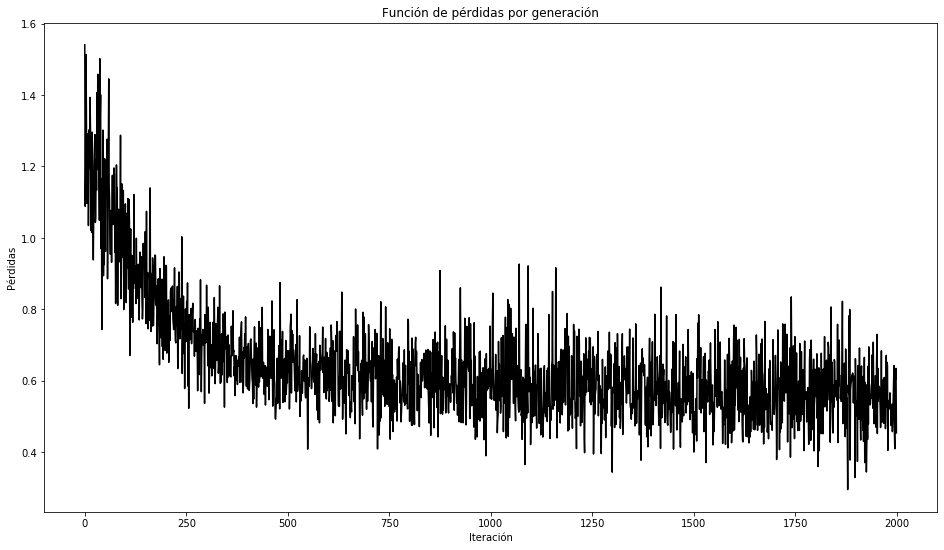

In [473]:
plt.figure(figsize = (16, 9))
plt.plot(loss_vect, "k-")
plt.title("Función de pérdidas por generación")
plt.xlabel("Iteración")
plt.ylabel("Pérdidas")
plt.show()

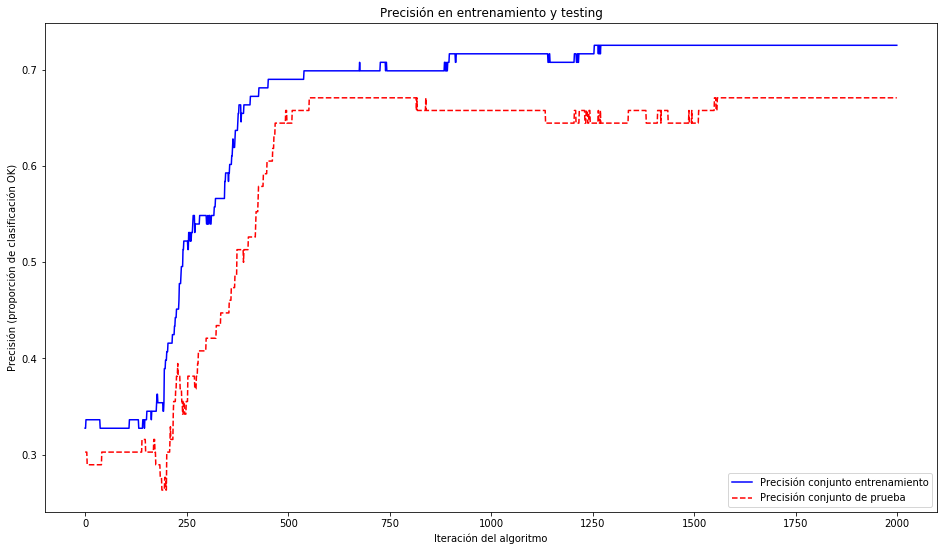

In [474]:
plt.figure(figsize = (16, 9))
plt.plot(train_accuracy, "b-", label = "Precisión conjunto entrenamiento")
plt.plot(test_accuracy, "r--", label = "Precisión conjunto de prueba")
plt.title("Precisión en entrenamiento y testing")
plt.xlabel("Iteración del algoritmo")
plt.ylabel("Precisión (proporción de clasificación OK)")
plt.legend(loc = "lower right")
plt.show()